# Sock Market Screener

1) pré-sélection de la liste d'actions

2) test de la strat sur la liste d'actions

3) Affiner la sélection d'actions

4) Afficher les alertes en temps réel sur les actions

In [75]:
# Imports
from tradingview_screener import Query, col
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta  # Technical Analysis Indicators
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import requests
from io import StringIO

# 1) pré-sélection de la liste d'actions

Critères de sélection des actions :
- marché Nasdaq et NYSE
- price 25 to 250 USD
- market cap supérieur ou égal à 1B USD
- Avg Volume 30D supérieur à 1M
- Volume supérieur à 1M
- Change supérieur à 0%
- Rel Vol at Time supérieur à 1.2
- SMA(50) inférieur au prix
- SMA(100) inférieur au prix
- SAM(200) inférieur au prix
- VWAP 5m inférieur ou égal au prix
- EMA(8) 5m inférieur ou égal au prix

In [89]:
#TradingView screener

# Requête choix des actions long
tickers = (
    Query()
    .select('name', 'close', 'volume', 'relative_volume_10d_calc')
    .where(
        col('type') == 'stock',
        col('exchange').isin(['NASDAQ', 'NYSE']),
        col('close').between(25, 250),
        col('market_cap_basic') >= 1_000_000_000,
        col('average_volume_30d_calc') > 1_000_000,
        col('volume') > 1_000_000,
        col('change') > 0,
        col('relative_volume') > 1.2,
        col('SMA50') < col('close'),
        col('SMA100') < col('close'),
        col('SMA200') < col('close'),
        #les 2 dernières conditions ne sont pas dispos en 5m avec l'API
    )
    .order_by('volume', ascending=False)
    .limit(3000)
    .get_scanner_data()
)

# Affichage
#print(tickers)
#tickers est au format tuple

# Extraction du DataFrame depuis le tuple
df = tickers[1]

# Extraction de la colonne 'name' sous forme de liste
tickers_list = df['name'].tolist()

# Affichage
print(tickers_list)

print("Il y a",len(tickers_list), "actions extraites" )


['NEGG']
Il y a 1 actions extraites


In [72]:
#Rajout des 2 dernières conditions avec yahoo finance

results = []

for symbol in tickers_list:
    try:
        ticker = yf.Ticker(symbol)
        info = ticker.info
        price = info.get('currentPrice')
        vol = info.get('volume', 0)

        # Données intraday 5m pour VWAP et EMA8
        intraday = ticker.history(period='1d', interval='5m')
        if len(intraday) < 8: continue

        vwap = (intraday['Close'] * intraday['Volume']).cumsum() / intraday['Volume'].cumsum()
        vwap_last = vwap.iloc[-1]
        ema8 = intraday['Close'].ewm(span=8, adjust=False).mean().iloc[-1]

        if not (vwap_last <= price and ema8 <= price): continue

        results.append({
            'ticker': symbol,
        })

    except Exception:
        continue

df = pd.DataFrame(results)
print(df)

print("Il y a",len(df), "actions sélectionnées pour tester la stratégie" )


Empty DataFrame
Columns: []
Index: []
Il y a 0 actions sélectionnées pour tester la stratégie


In [73]:
#Rajout de la vwap sans ema8

results = []

for symbol in tickers_list:
    try:
        ticker = yf.Ticker(symbol)
        info = ticker.info
        price = info.get('currentPrice')
        vol = info.get('volume', 0)

        # Données intraday 5m pour VWAP et EMA8
        intraday = ticker.history(period='1d', interval='5m')

        vwap = (intraday['Close'] * intraday['Volume']).cumsum() / intraday['Volume'].cumsum()
        vwap_last = vwap.iloc[-1]

        if not (vwap_last <= price): continue
        results.append({
            'ticker': symbol,
        })

    except Exception:
        continue

df = pd.DataFrame(results)
print(df)

print("Il y a",len(df), "actions sélectionnées pour tester la stratégie" )


Empty DataFrame
Columns: []
Index: []
Il y a 0 actions sélectionnées pour tester la stratégie


# 2) test de la strat sur la liste d'actions

In [74]:
tickers_list = ["AAPL", "MSFT", "NVDA", "AMZN", "META"]

df.head()

""


In [49]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def ATR(df, length):
    hl = df['high'] - df['low']
    hc = (df['high'] - df['close'].shift(1)).abs()
    lc = (df['low'] - df['close'].shift(1)).abs()
    tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
    return tr.rolling(length).mean()

def VWAP(df):
    tp = (df['high'] + df['low'] + df['close']) / 3
    cum_vp = (tp * df['volume']).cumsum()
    cum_vol = df['volume'].cumsum()
    return cum_vp / cum_vol

def power_index(df, pc_len, atr_len):
    return (df['close'] - df['close'].shift(pc_len)) / ATR(df, atr_len)

def buy_sell_strategy_full(
    df_5m, df_15m, df_30m, df_1d,
    df_spy_5m, df_spy_15m, df_spy_30m, df_spy_1d,
    initial_capital=10000, leverage=1, alloc_cap_per_trade_pct=25,
    monthly_goal=1100, trades_per_month=50, winrate_pct=70,
    absolute_profit=60, return_perc=1, risk_perc=1,
    volume_sma_len=78, exclude_first_x_min=30,
    atr_len_keybar=390, atr_mult_keybar=1, vol_avg_len_keybar=390, body_size_pct_keybar=75,
    pc_len_rrs=12, atr_len_rrs=12,
    days_rel_vol=5, high_rvol_thres=1.5, caution_rvol_thres=1.2,
    nATRPeriod_stop=12, nATRMultip_stop=3.5
):
    # --- Alignement des index ---
    df_5m = df_5m.copy()
    df_15m = df_15m.reindex(df_5m.index, method='ffill')
    df_30m = df_30m.reindex(df_5m.index, method='ffill')
    df_1d = df_1d.reindex(df_5m.index, method='ffill')
    df_spy_5m = df_spy_5m.reindex(df_5m.index, method='ffill')
    df_spy_15m = df_spy_15m.reindex(df_5m.index, method='ffill')
    df_spy_30m = df_spy_30m.reindex(df_5m.index, method='ffill')
    df_spy_1d = df_spy_1d.reindex(df_5m.index, method='ffill')

    # --- Variables multi-timeframe ---
    hod = df_1d['high']
    lod = df_1d['low']
    hod_1 = hod.shift(1)
    lod_1 = lod.shift(1)

    # --- Calculs Targets & Size ---
    available_capital = (initial_capital * leverage) * (alloc_cap_per_trade_pct / 100)
    strat_max_loss = (absolute_profit - ((monthly_goal / trades_per_month) * (winrate_pct / 100))) * ((winrate_pct / 100) / (1 - (winrate_pct / 100)))
    profit_target_rel = 1 + return_perc / 100
    loss_target_rel = 1 - risk_perc / 100
    trade_size = available_capital / df_5m['close']

    # --- Keybars ---
    atr_val_kb = ATR(df_5m, atr_len_keybar)
    vol_avg_kb = df_5m['volume'].rolling(vol_avg_len_keybar).mean()
    body_size = (df_5m['close'] - df_5m['open']).abs()
    total_range = df_5m['high'] - df_5m['low']
    is_keybar = (body_size >= atr_mult_keybar * atr_val_kb) & ((body_size / total_range) >= (body_size_pct_keybar / 100)) & (df_5m['volume'] > vol_avg_kb)
    bullish_keybar = is_keybar & (df_5m['close'] > df_5m['open'])
    bearish_keybar = is_keybar & (df_5m['close'] < df_5m['open'])

    # --- Heikin Ashi ---
    ha_close = (df_5m['open'] + df_5m['high'] + df_5m['low'] + df_5m['close']) / 4
    ha_open = ha_close.copy()
    ha_open.iloc[0] = (df_5m['open'].iloc[0] + df_5m['close'].iloc[0]) / 2
    for i in range(1, len(ha_open)):
        ha_open.iloc[i] = (ha_open.iloc[i-1] + ha_close.iloc[i-1]) / 2

    ha_high = pd.concat([df_5m['high'], ha_open, ha_close], axis=1).max(axis=1)
    ha_low = pd.concat([df_5m['low'], ha_open, ha_close], axis=1).min(axis=1)

    ha_green = ha_close > ha_open
    ha_red = ha_close < ha_open
    green_diff = (ha_low - ha_open).abs()
    red_diff = (ha_high - ha_open).abs()
    tolerance = 0.01 * (df_5m['close'].diff().abs().min())

    is_flat_green = ha_green & (green_diff <= tolerance)
    is_flat_red = ha_red & (red_diff <= tolerance)
    red_strike = ha_red.shift(1) & ha_red.shift(2) & ha_red.shift(3)
    green_strike = ha_green.shift(1) & ha_green.shift(2) & ha_green.shift(3)
    bullish_reversal = is_flat_green & red_strike & ~(is_flat_green.shift(1) & red_strike.shift(1)) & (df_5m['close'] > df_5m['open'])
    bearish_reversal = is_flat_red & green_strike & ~(is_flat_red.shift(1) & green_strike.shift(1)) & (df_5m['close'] < df_5m['open'])

    # --- RRS ---
    stock_pi_5 = power_index(df_5m, pc_len_rrs, atr_len_rrs)
    stock_pi_15 = power_index(df_15m, pc_len_rrs, atr_len_rrs)
    stock_pi_30 = power_index(df_30m, pc_len_rrs, atr_len_rrs)
    stock_pi_1d = power_index(df_1d, pc_len_rrs, atr_len_rrs)
    spy_pi_5 = power_index(df_spy_5m, pc_len_rrs, atr_len_rrs)
    spy_pi_15 = power_index(df_spy_15m, pc_len_rrs, atr_len_rrs)
    spy_pi_30 = power_index(df_spy_30m, pc_len_rrs, atr_len_rrs)
    spy_pi_1d = power_index(df_spy_1d, pc_len_rrs, atr_len_rrs)
    rrs_5m = stock_pi_5 - spy_pi_5
    rrs_15m = stock_pi_15 - spy_pi_15
    rrs_30m = stock_pi_30 - spy_pi_30
    rrs_1d = stock_pi_1d - spy_pi_1d
    rrs_30m_cross = (rrs_30m.shift(1) < 0) & (rrs_30m > 0)
    rrs_30m_crossunder = (rrs_30m.shift(1) > 0) & (rrs_30m < 0)

    # --- VWAP ---
    vwap_5 = VWAP(df_5m)
    vwap_15 = VWAP(df_15m)
    vwap_30 = VWAP(df_30m)
    keybar_breakout_vwap = bullish_keybar & (df_5m['open'] < vwap_5) & (df_5m['close'] > vwap_5)
    keybar_breakdown_vwap = bearish_keybar & (df_5m['open'] > vwap_5) & (df_5m['close'] < vwap_5)

    # --- Relative volume ---
    rvol = df_5m['volume'] / df_5m['volume'].rolling(days_rel_vol).mean()

    # --- ATR trailing stop ---
    atr_stop = ATR(df_5m, nATRPeriod_stop)
    nLoss = nATRMultip_stop * atr_stop
    xATRTrailingStop = pd.Series(index=df_5m.index, dtype=float)
    pos = pd.Series(index=df_5m.index, dtype=float)
    for i in range(len(df_5m)):
        if i == 0:
            xATRTrailingStop.iloc[i] = df_5m['close'].iloc[i] - nLoss.iloc[i]
            pos.iloc[i] = 0
            continue
        prev_stop = xATRTrailingStop.iloc[i-1]
        if pos.iloc[i-1] == 1:
            xATRTrailingStop.iloc[i] = max(prev_stop, df_5m['close'].iloc[i] - nLoss.iloc[i])
        elif pos.iloc[i-1] == -1:
            xATRTrailingStop.iloc[i] = min(prev_stop, df_5m['close'].iloc[i] + nLoss.iloc[i])
        else:
            xATRTrailingStop.iloc[i] = df_5m['close'].iloc[i] - nLoss.iloc[i]
        # Position
        if df_5m['close'].iloc[i] > prev_stop and pos.iloc[i-1] <= 0:
            pos.iloc[i] = 1
        elif df_5m['close'].iloc[i] < prev_stop and pos.iloc[i-1] >= 0:
            pos.iloc[i] = -1
        else:
            pos.iloc[i] = pos.iloc[i-1]

    atr_trailing_bullish_cross = (pos.shift(1) == -1) & (pos == 1)
    atr_trailing_bearish_cross = (pos.shift(1) == 1) & (pos == -1)

    # --- Signaux finaux ---
    aligned_RS = (rrs_15m > 0) & (rrs_5m > 0)
    aligned_RW = (rrs_15m < 0) & (rrs_5m < 0)
    vol_above_avg = df_5m['volume'] > df_5m['volume'].rolling(volume_sma_len).mean()
    high_rel_vol = rvol >= caution_rvol_thres
    is_long_bullish = (df_5m['close'] > df_5m['open']) & (body_size >= 0.8 * ATR(df_5m, 12)) & ((body_size / total_range) >= 0.8)
    is_long_bearish = (df_5m['close'] < df_5m['open']) & (body_size >= 0.8 * ATR(df_5m, 12)) & ((body_size / total_range) >= 0.8)
    bullish_thrust = ((is_long_bullish & is_long_bullish.shift(1)) | (bullish_keybar & bullish_keybar.shift(1)))
    bearish_thrust = ((is_long_bearish & is_long_bearish.shift(1)) | (bearish_keybar & bearish_keybar.shift(1)))
    hod1_breakout = is_long_bullish & (df_5m['open'] < hod_1) & (df_5m['close'] > hod_1)
    lod1_breakdown = is_long_bearish & (df_5m['open'] > lod_1) & (df_5m['close'] < lod_1)

    enter_long = aligned_RS & (vol_above_avg | high_rel_vol) & (
        bullish_reversal | keybar_breakout_vwap | bullish_thrust | atr_trailing_bullish_cross | rrs_30m_cross | hod1_breakout
    )
    exit_long = bearish_reversal
    enter_short = aligned_RW & (vol_above_avg | high_rel_vol) & (
        bearish_reversal | keybar_breakdown_vwap | bearish_thrust | atr_trailing_bearish_cross | rrs_30m_crossunder | lod1_breakdown
    )
    exit_short = bullish_reversal

    return {
        'Enter_Long': enter_long.fillna(False),
        'Exit_Long': exit_long.fillna(False),
        'Enter_Short': enter_short.fillna(False),
        'Exit_Short': exit_short.fillna(False),
        'ATR_Stop': xATRTrailingStop,
        'Pos': pos
    }

def fetch_5m_data(tickers, start, end):
    df = yf.download(
        tickers,
        start=start,
        end=end,
        interval="5m",
        group_by="ticker",
        threads=True,
        auto_adjust=False
    )
    if not isinstance(df.columns, pd.MultiIndex):
        df = pd.concat({tickers[0]: df}, axis=1)
    return df

def split_by_ticker_normalized(df_multi):
    tickers = df_multi.columns.levels[0]
    return {t: df_multi[t].rename(columns=str.lower) for t in tickers}

def build_timeframes_from_5m(df5):
    def resample_tf(df, rule):
        return df.resample(rule).agg({
            "open": "first",
            "high": "max",
            "low": "min",
            "close": "last",
            "volume": "sum"
        })
    return (
        resample_tf(df5, "15T"),
        resample_tf(df5, "30T"),
        resample_tf(df5, "1D")
    )

def get_all_timeframes_for_ticker(ticker, start, end):
    df5_all = fetch_5m_data([ticker], start, end)
    df5_dict = split_by_ticker_normalized(df5_all)
    df5 = df5_dict[ticker]
    df5.index = pd.to_datetime(df5.index)
    df15, df30, df1d = build_timeframes_from_5m(df5)
    return df5, df15, df30, df1d


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_7319/2287465979.py:193: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return df.resample(rule).agg({
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_7319/2287465979.py:193: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return df.resample(rule).agg({
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_7319/2287465979.py:193: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return df.resample(rule).agg({
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_7319/2287465979.py:193: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return df.resample(rule).agg({
[*********************100%**********


--- Enter_Long ---
Datetime
2025-08-13 19:35:00+00:00    False
2025-08-13 19:40:00+00:00    False
2025-08-13 19:45:00+00:00    False
2025-08-13 19:50:00+00:00    False
2025-08-13 19:55:00+00:00    False
dtype: bool

--- Exit_Long ---
Datetime
2025-08-13 19:35:00+00:00    False
2025-08-13 19:40:00+00:00    False
2025-08-13 19:45:00+00:00    False
2025-08-13 19:50:00+00:00    False
2025-08-13 19:55:00+00:00    False
dtype: bool

--- Enter_Short ---
Datetime
2025-08-13 19:35:00+00:00    False
2025-08-13 19:40:00+00:00    False
2025-08-13 19:45:00+00:00    False
2025-08-13 19:50:00+00:00    False
2025-08-13 19:55:00+00:00    False
dtype: bool

--- Exit_Short ---
Datetime
2025-08-13 19:35:00+00:00    False
2025-08-13 19:40:00+00:00    False
2025-08-13 19:45:00+00:00    False
2025-08-13 19:50:00+00:00    False
2025-08-13 19:55:00+00:00    False
dtype: bool

--- ATR_Stop ---
Datetime
2025-08-13 19:35:00+00:00    232.613288
2025-08-13 19:40:00+00:00    232.613288
2025-08-13 19:45:00+00:00    

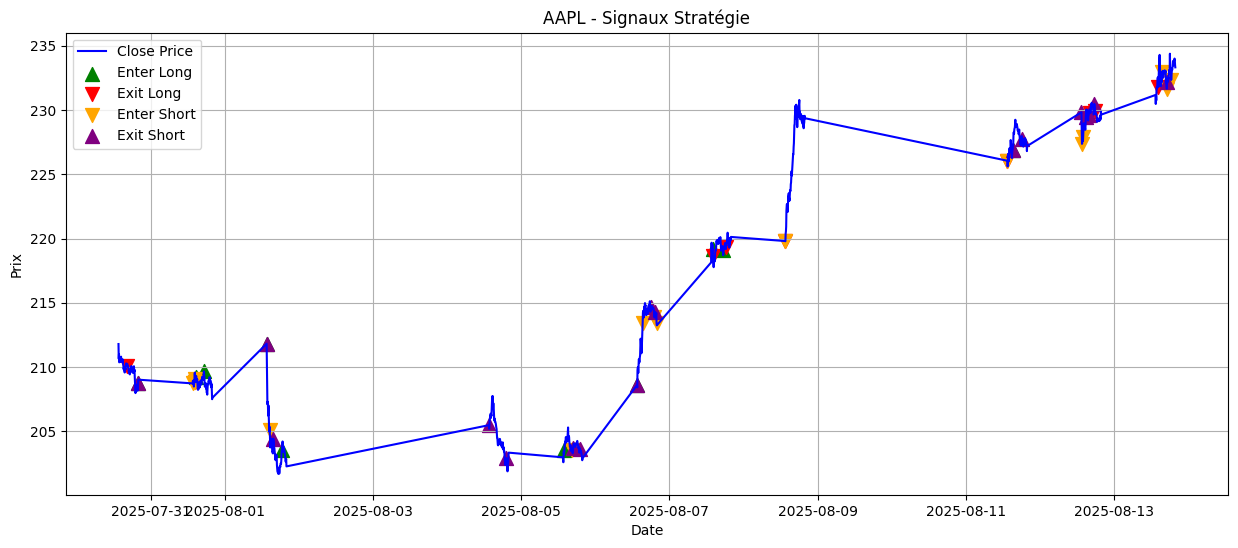

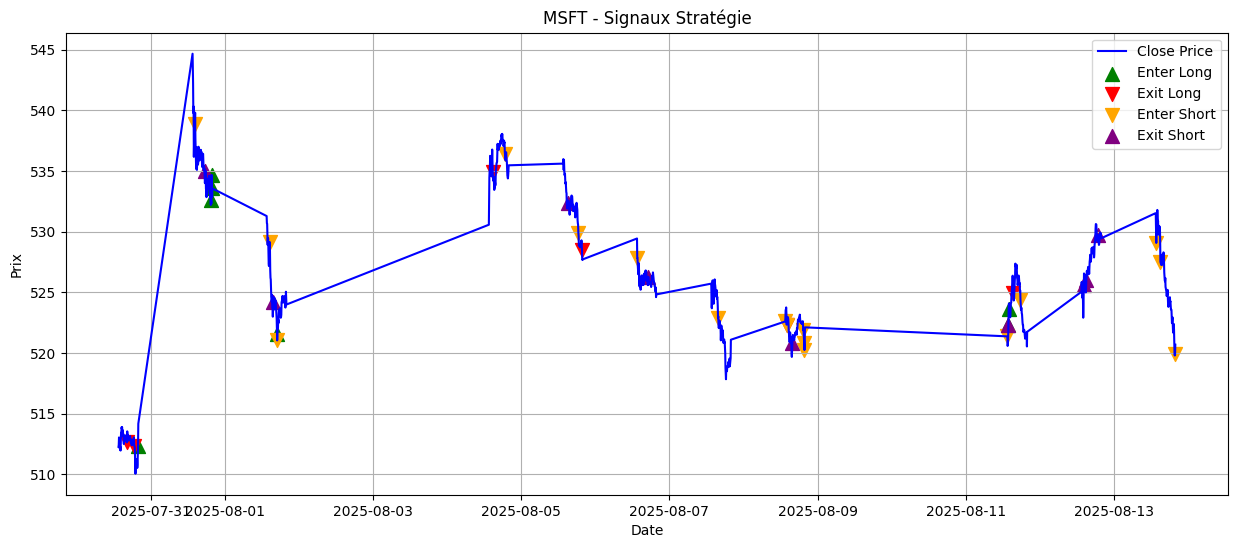

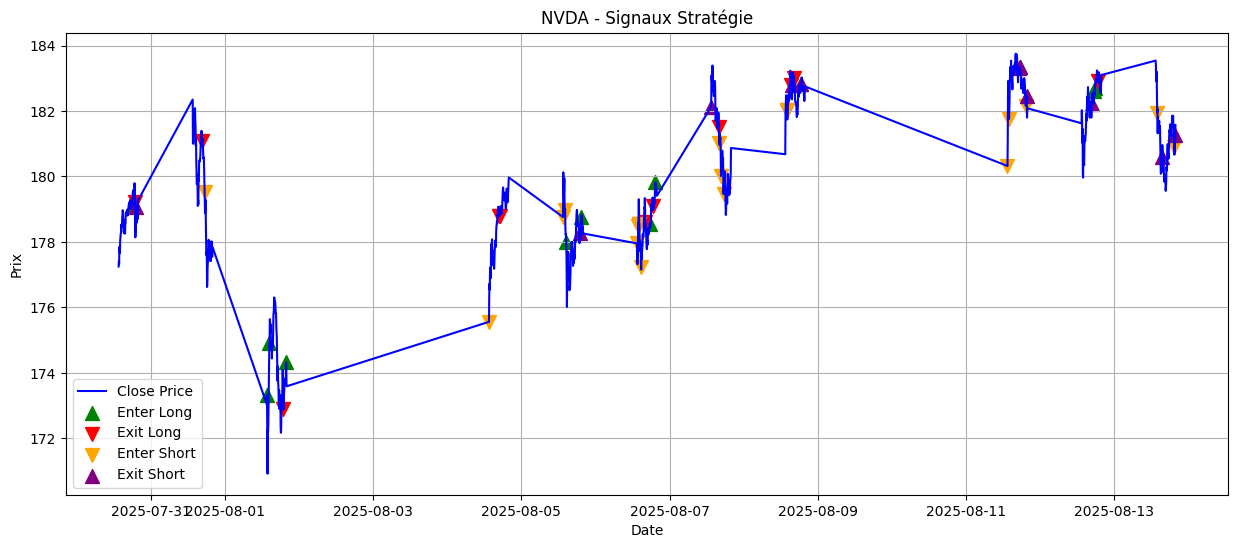

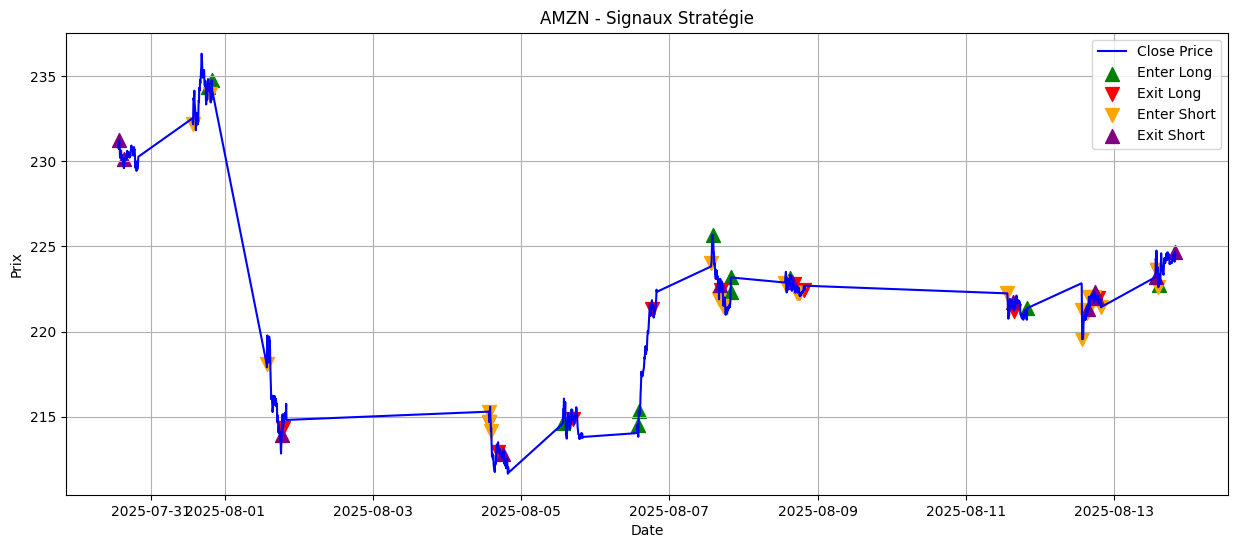

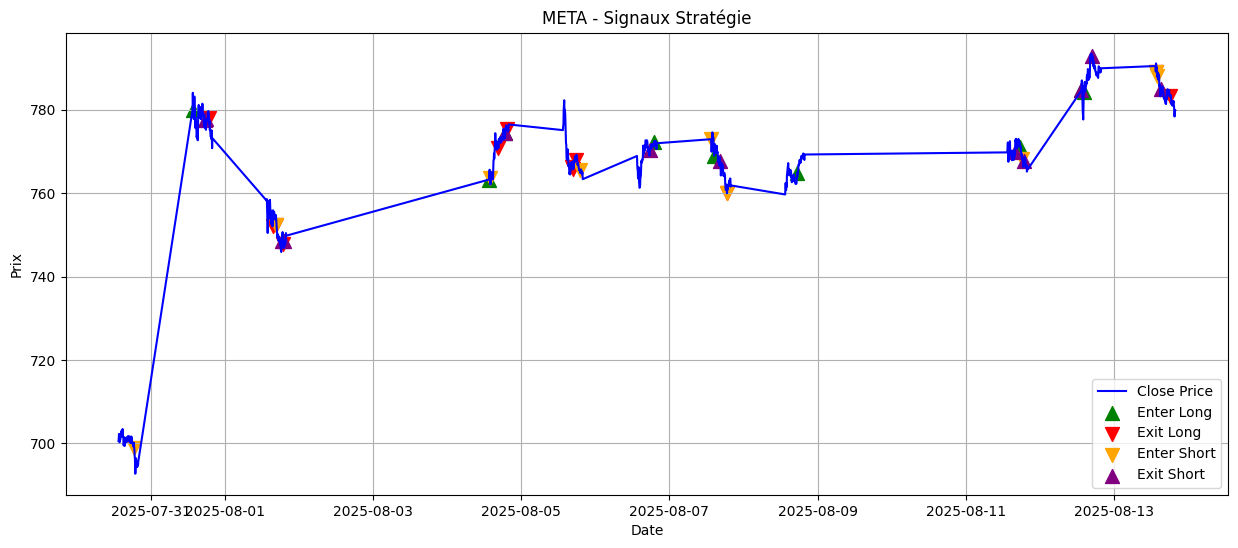

In [45]:
# --- Paramètres ---
end = datetime.today().strftime('%Y-%m-%d')
start = (pd.to_datetime(end) - pd.Timedelta(days=15)).strftime('%Y-%m-%d')

# --- Télécharger SPY ---
spy_5m, spy_15m, spy_30m, spy_1d = get_all_timeframes_for_ticker("SPY", start, end)

# --- Télécharger tous les tickers et lancer la stratégie ---
results = {}
dfs_5min = {}
for t in tickers_list:
    df5_t, df15_t, df30_t, df1d_t = get_all_timeframes_for_ticker(t, start, end)
    dfs_5min[t] = df5_t
    res = buy_sell_strategy_full(
        df5_t, df15_t, df30_t, df1d_t,
        spy_5m, spy_15m, spy_30m, spy_1d
    )
    results[t] = res

# --- Affichage des signaux pour AAPL ---
for key, df in results["AAPL"].items():
    print(f"\n--- {key} ---")
    print(df.tail())

# --- Fonction de tracé ---
def plot_signals(df, signals, ticker):
    plt.figure(figsize=(15,6))
    plt.plot(df['close'], label='Close Price', color='blue')
    if 'Enter_Long' in signals:
        plt.scatter(df.index[signals['Enter_Long']], df['close'][signals['Enter_Long']],
                    marker='^', color='green', s=100, label='Enter Long')
    if 'Exit_Long' in signals:
        plt.scatter(df.index[signals['Exit_Long']], df['close'][signals['Exit_Long']],
                    marker='v', color='red', s=100, label='Exit Long')
    if 'Enter_Short' in signals:
        plt.scatter(df.index[signals['Enter_Short']], df['close'][signals['Enter_Short']],
                    marker='v', color='orange', s=100, label='Enter Short')
    if 'Exit_Short' in signals:
        plt.scatter(df.index[signals['Exit_Short']], df['close'][signals['Exit_Short']],
                    marker='^', color='purple', s=100, label='Exit Short')
    plt.title(f"{ticker} - Signaux Stratégie")
    plt.xlabel("Date")
    plt.ylabel("Prix")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Tracé pour tous les tickers ---
for ticker, signals in results.items():
    df_price = dfs_5min[ticker]
    plot_signals(df_price, signals, ticker)


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_7319/2287465979.py:193: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return df.resample(rule).agg({
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_7319/2287465979.py:193: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return df.resample(rule).agg({
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_7319/2287465979.py:193: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return df.resample(rule).agg({
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_7319/2287465979.py:193: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return df.resample(rule).agg({
[*********************100%**********


--- Enter_Long ---
Datetime
2025-08-13 19:35:00+00:00    False
2025-08-13 19:40:00+00:00    False
2025-08-13 19:45:00+00:00    False
2025-08-13 19:50:00+00:00    False
2025-08-13 19:55:00+00:00    False
dtype: bool

--- Exit_Long ---
Datetime
2025-08-13 19:35:00+00:00    False
2025-08-13 19:40:00+00:00    False
2025-08-13 19:45:00+00:00    False
2025-08-13 19:50:00+00:00    False
2025-08-13 19:55:00+00:00    False
dtype: bool

--- Enter_Short ---
Datetime
2025-08-13 19:35:00+00:00    False
2025-08-13 19:40:00+00:00    False
2025-08-13 19:45:00+00:00    False
2025-08-13 19:50:00+00:00    False
2025-08-13 19:55:00+00:00    False
dtype: bool

--- Exit_Short ---
Datetime
2025-08-13 19:35:00+00:00    False
2025-08-13 19:40:00+00:00    False
2025-08-13 19:45:00+00:00    False
2025-08-13 19:50:00+00:00    False
2025-08-13 19:55:00+00:00    False
dtype: bool

--- ATR_Stop ---
Datetime
2025-08-13 19:35:00+00:00    232.613288
2025-08-13 19:40:00+00:00    232.613288
2025-08-13 19:45:00+00:00    

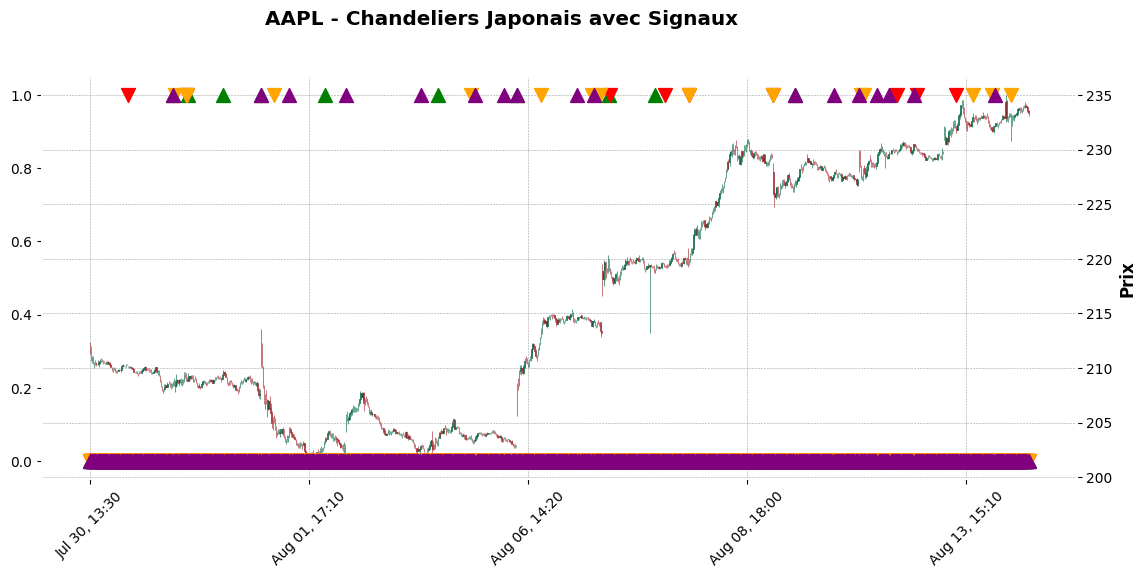

/home/audrey/anaconda3/envs/trading/lib/python3.13/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


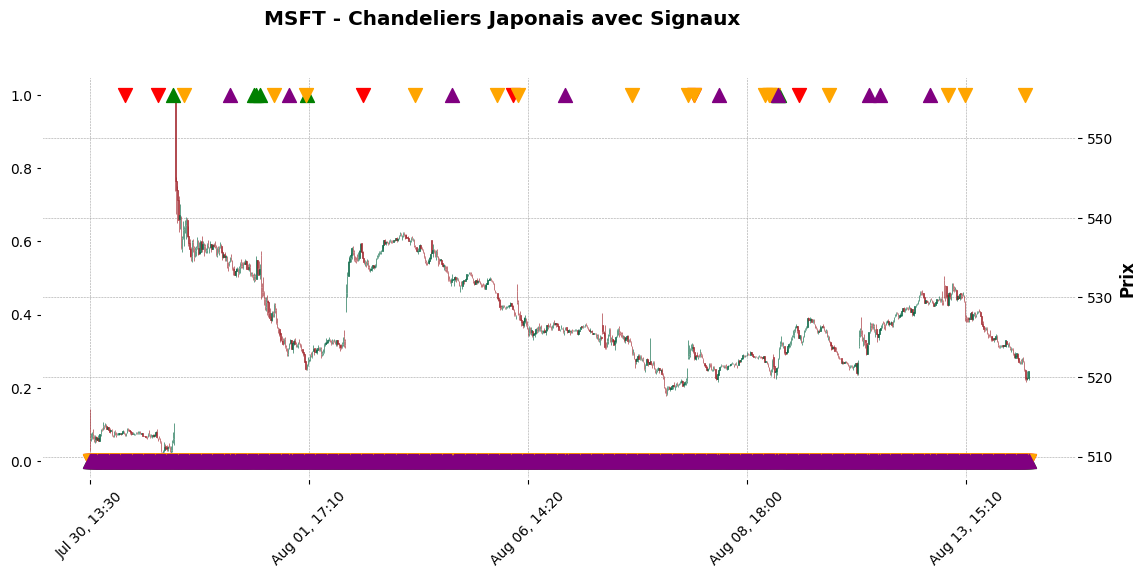

/home/audrey/anaconda3/envs/trading/lib/python3.13/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


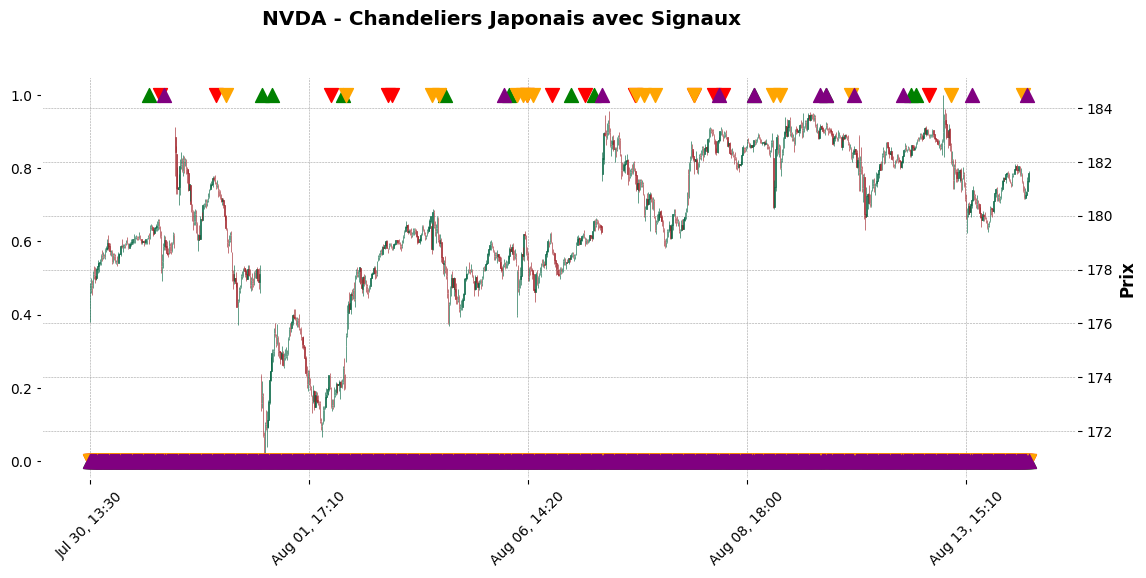

/home/audrey/anaconda3/envs/trading/lib/python3.13/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


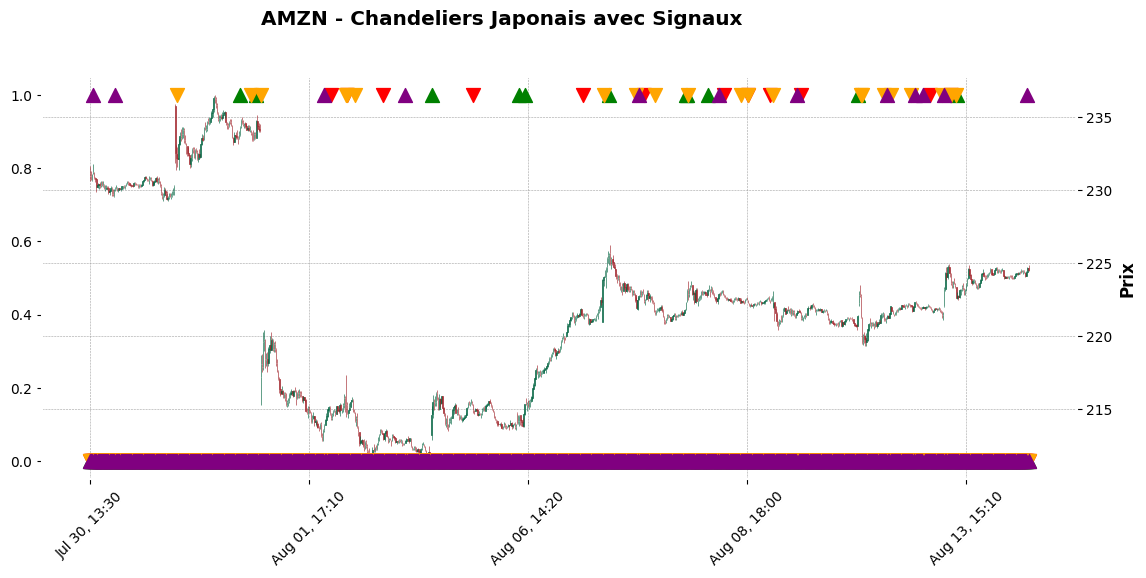

/home/audrey/anaconda3/envs/trading/lib/python3.13/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


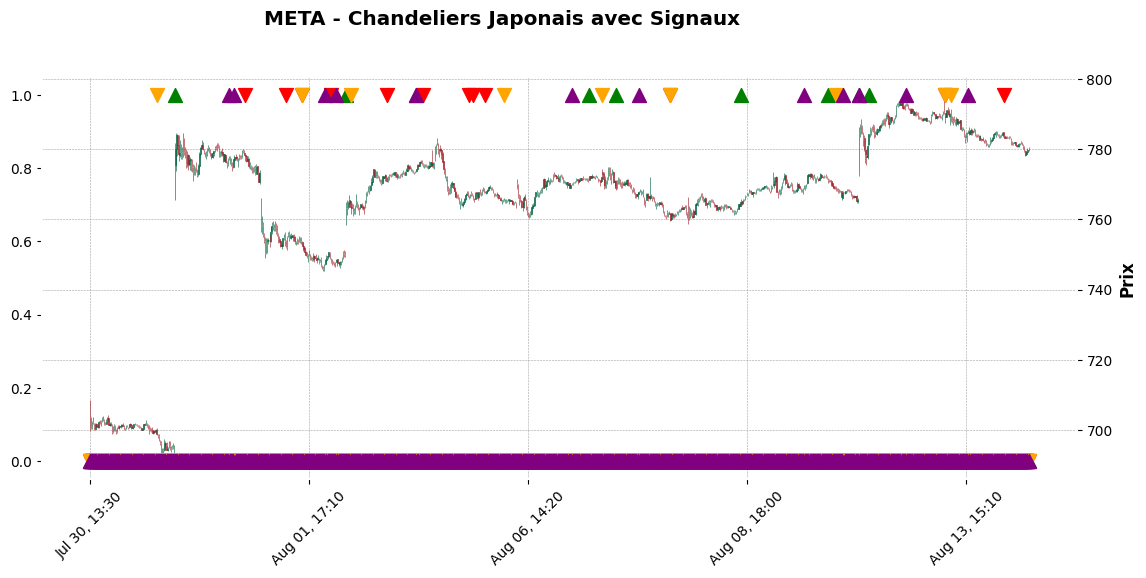

In [54]:
import mplfinance as mpf
import matplotlib.colors as mcolors

# --- Paramètres ---
#tickers_list = ["AAPL", "MSFT", "NVDA", "AMZN", "META"]
end = datetime.today().strftime('%Y-%m-%d')
start = (pd.to_datetime(end) - pd.Timedelta(days=15)).strftime('%Y-%m-%d')

# --- Télécharger SPY ---
spy_5m, spy_15m, spy_30m, spy_1d = get_all_timeframes_for_ticker("SPY", start, end)

# --- Télécharger tous les tickers et lancer la stratégie ---
results = {}
dfs_5min = {}
for t in tickers_list:
    df5_t, df15_t, df30_t, df1d_t = get_all_timeframes_for_ticker(t, start, end)
    dfs_5min[t] = df5_t
    res = buy_sell_strategy_full(
        df5_t, df15_t, df30_t, df1d_t,
        spy_5m, spy_15m, spy_30m, spy_1d
    )
    results[t] = res

# --- Affichage des signaux pour AAPL ---
for key, df in results["AAPL"].items():
    print(f"\n--- {key} ---")
    print(df.tail())

import mplfinance as mpf
import pandas as pd

def plot_signals(df, signals, ticker):
    # Copie du DataFrame original
    df_plot = df.copy()

    # Ajout des signaux comme colonnes
    df_plot['Enter_Long'] = signals['Enter_Long'].astype(int)
    df_plot['Exit_Long'] = signals['Exit_Long'].astype(int)
    df_plot['Enter_Short'] = signals['Enter_Short'].astype(int)
    df_plot['Exit_Short'] = signals['Exit_Short'].astype(int)

    # Création des flèches pour les signaux
    enter_long_arrows = mpf.make_addplot(
        df_plot['Enter_Long'], type='scatter', markersize=100, marker='^', color='green', panel=0
    )
    exit_long_arrows = mpf.make_addplot(
        df_plot['Exit_Long'], type='scatter', markersize=100, marker='v', color='red', panel=0
    )
    enter_short_arrows = mpf.make_addplot(
        df_plot['Enter_Short'], type='scatter', markersize=100, marker='v', color='orange', panel=0
    )
    exit_short_arrows = mpf.make_addplot(
        df_plot['Exit_Short'], type='scatter', markersize=100, marker='^', color='purple', panel=0
    )

    # Affichage des chandeliers avec les signaux
    mpf.plot(
        df_plot,
        type='candle',
        style='charles',
        title=f"{ticker} - Chandeliers Japonais avec Signaux",
        ylabel='Prix',
        volume=False,
        addplot=[
            enter_long_arrows,
            exit_long_arrows,
            enter_short_arrows,
            exit_short_arrows,
        ],
        figratio=(15, 6),
        figscale=1.0,
    )


for ticker, signals in results.items():
    df_price = dfs_5min[ticker]
    # Vérifie et convertit l'index si nécessaire
    if not isinstance(df_price.index, pd.DatetimeIndex):
        df_price.index = pd.to_datetime(df_price.index)
    plot_signals(df_price, signals, ticker)



In [60]:
import numpy as np
import pandas as pd

def calculate_metrics(df_price, signals, initial_capital=10000, alloc_cap_per_trade_pct=25, leverage=1):
    """
    Calcule les métriques de performance pour un ticker donné.

    Args:
        df_price (pd.DataFrame): DataFrame avec les prix OHLCV.
        signals (dict): Dictionnaire des signaux ('Enter_Long', 'Exit_Long', 'Enter_Short', 'Exit_Short').
        initial_capital (float): Capital initial.
        alloc_cap_per_trade_pct (float): Pourcentage du capital alloué par trade.
        leverage (float): Effet de levier.

    Returns:
        dict: Dictionnaire des métriques calculées.
    """
    # --- Préparation des données ---
    df = df_price.copy()
    df['Enter_Long'] = signals['Enter_Long']
    df['Exit_Long'] = signals['Exit_Long']
    df['Enter_Short'] = signals['Enter_Short']
    df['Exit_Short'] = signals['Exit_Short']

    # --- Calcul des trades ---
    trades = []
    position = 0  # 0: pas de position, 1: long, -1: short
    entry_price = 0
    capital = initial_capital
    capital_history = [capital]

    for i in range(1, len(df)):
        # Gestion des entrées/sorties de position longue
        if df['Enter_Long'].iloc[i] and position == 0:
            position = 1
            entry_price = df['close'].iloc[i]
        elif df['Exit_Long'].iloc[i] and position == 1:
            pnl = (df['close'].iloc[i] - entry_price) / entry_price
            capital += capital * (alloc_cap_per_trade_pct / 100) * leverage * pnl
            capital_history.append(capital)
            trades.append({
                'type': 'long',
                'entry': entry_price,
                'exit': df['close'].iloc[i],
                'pnl_pct': pnl * 100,
                'is_profitable': pnl > 0
            })
            position = 0

        # Gestion des entrées/sorties de position courte
        if df['Enter_Short'].iloc[i] and position == 0:
            position = -1
            entry_price = df['close'].iloc[i]
        elif df['Exit_Short'].iloc[i] and position == -1:
            pnl = (entry_price - df['close'].iloc[i]) / entry_price
            capital += capital * (alloc_cap_per_trade_pct / 100) * leverage * pnl
            capital_history.append(capital)
            trades.append({
                'type': 'short',
                'entry': entry_price,
                'exit': df['close'].iloc[i],
                'pnl_pct': pnl * 100,
                'is_profitable': pnl > 0
            })
            position = 0

    # --- Calcul des métriques ---
    if not trades:
        return {
            'nombre_de_trades': 0,
            'total_pnl_pct': 0,
            'taux_de_trades_rentables': 0,
            'ratio_risque_recompense': 0,
            'profit_moyen_pct': 0,
            'perte_moyenne_pct': 0,
            'max_drawdown_pct': 0,
            'sharpe_ratio': 0,
            'sortino_ratio': 0,
            'ratio_profitabilite': 0,
        }

    # Nombre de trades
    nombre_de_trades = len(trades)

    # Total P&L (%)
    total_pnl_pct = (capital - initial_capital) / initial_capital * 100

    # Taux de trades rentables (%)
    profitable_trades = [t for t in trades if t['is_profitable']]
    taux_de_trades_rentables = len(profitable_trades) / nombre_de_trades * 100

    # Profit moyen et perte moyenne (%)
    pnl_list = [t['pnl_pct'] for t in trades]
    profit_moyen_pct = np.mean([t['pnl_pct'] for t in trades if t['is_profitable']]) if profitable_trades else 0
    perte_moyenne_pct = np.mean([t['pnl_pct'] for t in trades if not t['is_profitable']]) if (nombre_de_trades - len(profitable_trades)) > 0 else 0

    # Ratio risque/récompense
    ratio_risque_recompense = abs(profit_moyen_pct / perte_moyenne_pct) if perte_moyenne_pct != 0 else 0

    # Max Drawdown (%)
    peak = np.maximum.accumulate(capital_history)
    drawdown = [(p - c) / p * 100 for p, c in zip(peak, capital_history)]
    max_drawdown_pct = max(drawdown)

    # Rendements quotidiens pour Sharpe et Sortino
    returns = np.diff(capital_history) / capital_history[:-1]
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    downside_returns = [r for r in returns if r < 0]
    downside_std = np.std(downside_returns) if downside_returns else 0.0001

    # Sharpe Ratio (suppose un taux sans risque de 0%)
    sharpe_ratio = mean_return / std_return if std_return != 0 else 0

    # Sortino Ratio
    sortino_ratio = mean_return / downside_std if downside_std != 0 else 0

    # Ratio de profitabilité
    ratio_profitabilite = len(profitable_trades) / (nombre_de_trades - len(profitable_trades)) if (nombre_de_trades - len(profitable_trades)) > 0 else 0

    return {
        'nombre_de_trades': nombre_de_trades,
        'total_pnl_pct': total_pnl_pct,
        'taux_de_trades_rentables': taux_de_trades_rentables,
        'ratio_risque_recompense': ratio_risque_recompense,
        'profit_moyen_pct': profit_moyen_pct,
        'perte_moyenne_pct': perte_moyenne_pct,
        'max_drawdown_pct': max_drawdown_pct,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'ratio_profitabilite': ratio_profitabilite,
        'capital_history': capital_history,  # Ajoute cette ligne
    }


In [58]:
# --- Paramètres ---
tickers_list = ["AAPL", "MSFT", "NVDA", "AMZN", "META"]
end = datetime.today().strftime('%Y-%m-%d')
start = (pd.to_datetime(end) - pd.Timedelta(days=15)).strftime('%Y-%m-%d')

# --- Télécharger SPY ---
spy_5m, spy_15m, spy_30m, spy_1d = get_all_timeframes_for_ticker("SPY", start, end)

# --- Télécharger tous les tickers et lancer la stratégie ---
results = {}
dfs_5min = {}
for t in tickers_list:
    df5_t, df15_t, df30_t, df1d_t = get_all_timeframes_for_ticker(t, start, end)
    dfs_5min[t] = df5_t
    res = buy_sell_strategy_full(
        df5_t, df15_t, df30_t, df1d_t,
        spy_5m, spy_15m, spy_30m, spy_1d
    )
    results[t] = res

# --- Calcul et affichage des métriques ---
metrics_results = {}
for ticker in tickers_list:
    df_price = dfs_5min[ticker]
    signals = results[ticker]
    metrics = calculate_metrics(df_price, signals)
    metrics_results[ticker] = metrics

# Affichage des résultats sous forme de tableau
metrics_df = pd.DataFrame(metrics_results).T
print("\n--- Métriques de Performance ---")
print(metrics_df)


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_7319/2287465979.py:193: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return df.resample(rule).agg({
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_7319/2287465979.py:193: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return df.resample(rule).agg({
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_7319/2287465979.py:193: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return df.resample(rule).agg({
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_7319/2287465979.py:193: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return df.resample(rule).agg({
[*********************100%**********


--- Métriques de Performance ---
      nombre_de_trades  total_pnl_pct  taux_de_trades_rentables  \
AAPL               8.0       0.645662                 62.500000   
MSFT               7.0       1.546709                 71.428571   
NVDA               8.0      -0.444660                 50.000000   
AMZN              10.0       2.890900                 70.000000   
META               9.0      -2.571831                 55.555556   

      ratio_risque_recompense  profit_moyen_pct  perte_moyenne_pct  \
AAPL                 0.885598          1.649114          -1.862149   
MSFT                 8.164436          1.296564          -0.158806   
NVDA                 0.468786          0.391575          -0.835295   
AMZN                 3.022521          1.912987          -0.632911   
META                 0.244487          0.901869          -3.688829   

      max_drawdown_pct  sharpe_ratio  sortino_ratio  ratio_profitabilite  
AAPL          1.038286      0.114391       0.337459             1.6

Interprétation des résultats

- Total P&L (%) : Si positif, la stratégie est globalement rentable.
- Taux de trades rentables : Un taux élevé (> 60%) est généralement bon.
- Ratio risque/récompense : Un ratio > 1 signifie que les gains moyens sont supérieurs aux pertes moyennes.
- Max Drawdown : Indique la pire perte enregistrée. Plus il est faible, mieux c'est.
- Sharpe Ratio : Un ratio > 1 est considéré comme bon.
- Sortino Ratio : Similaire au Sharpe Ratio, mais ne tient compte que de la volatilité des pertes.

In [61]:
import matplotlib.pyplot as plt

def plot_capital_curve(df_price, capital_history, ticker):
    """
    Trace la courbe de capital pour un ticker donné.

    Args:
        df_price (pd.DataFrame): DataFrame avec les prix OHLCV.
        capital_history (list): Historique du capital.
        ticker (str): Nom du ticker.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df_price.index[:len(capital_history)], capital_history, label='Capital', color='blue')
    plt.title(f"Courbe de Capital - {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Capital ($)")
    plt.grid(True)
    plt.legend()
    plt.show()


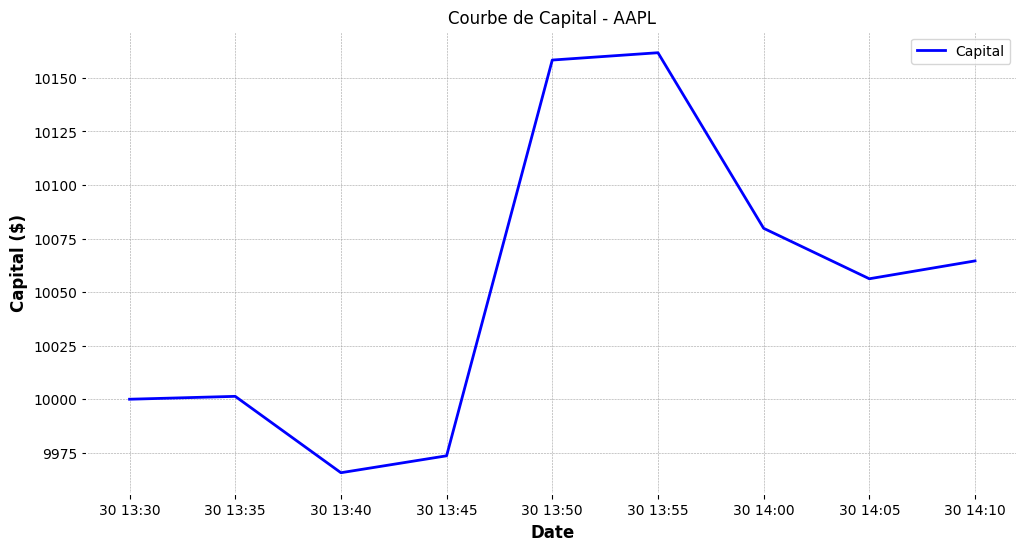

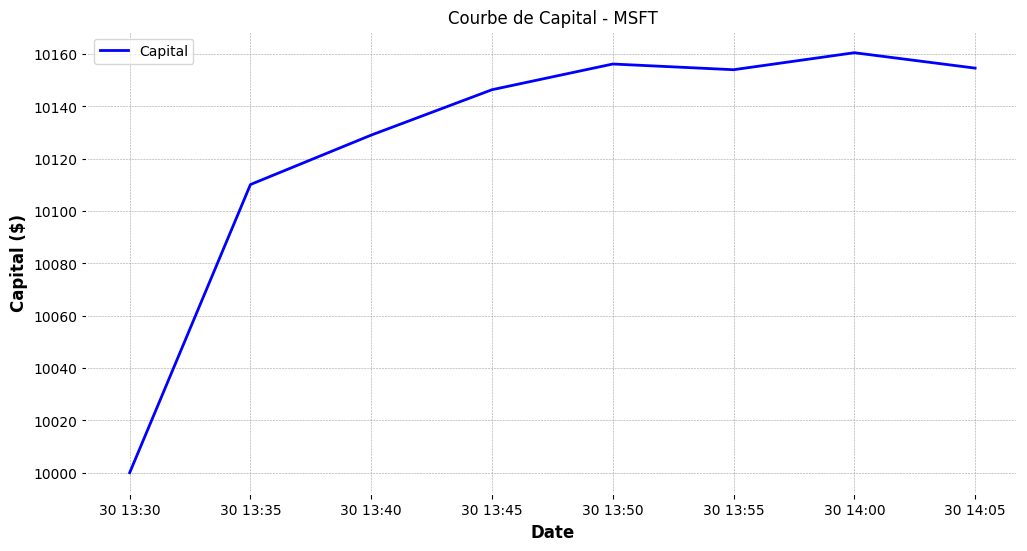

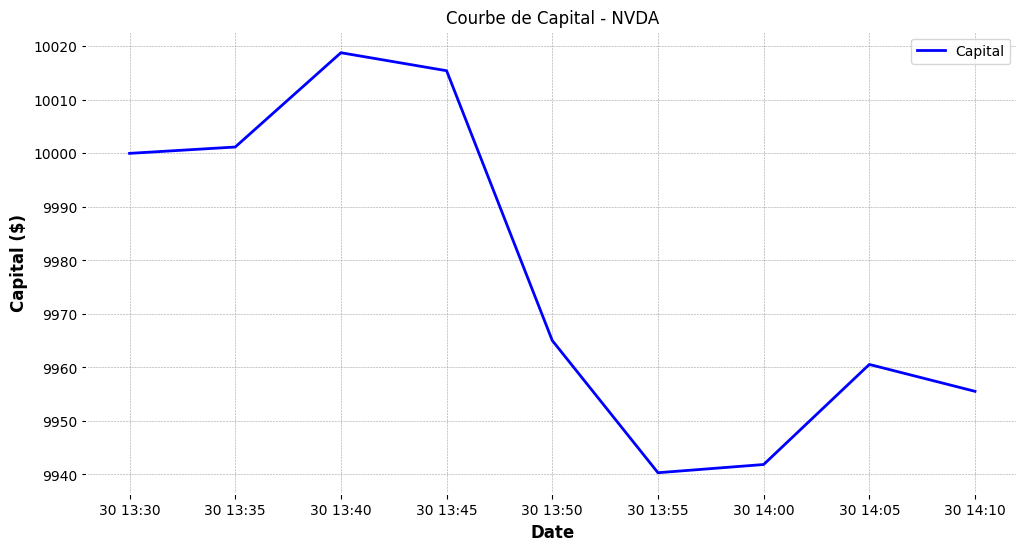

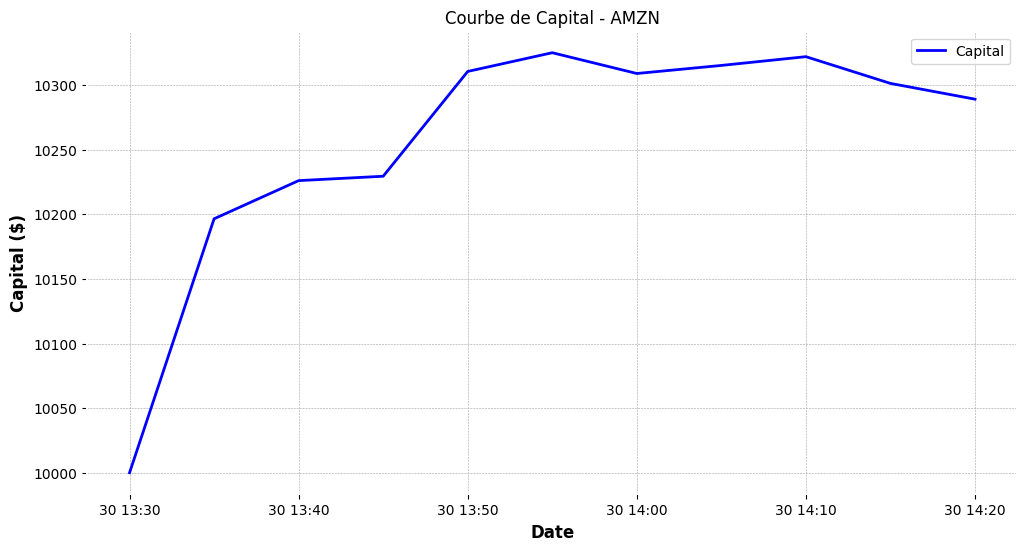

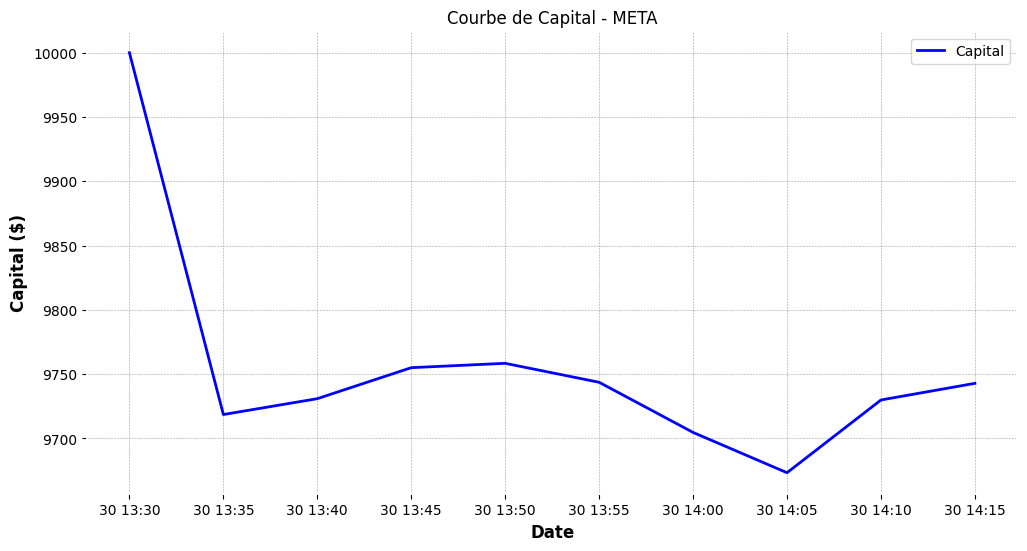


--- Métriques de Performance ---
     nombre_de_trades total_pnl_pct taux_de_trades_rentables  \
AAPL                8      0.645662                     62.5   
MSFT                7      1.546709                71.428571   
NVDA                8      -0.44466                     50.0   
AMZN               10        2.8909                     70.0   
META                9     -2.571831                55.555556   

     ratio_risque_recompense profit_moyen_pct perte_moyenne_pct  \
AAPL                0.885598         1.649114         -1.862149   
MSFT                8.164436         1.296564         -0.158806   
NVDA                0.468786         0.391575         -0.835295   
AMZN                3.022521         1.912987         -0.632911   
META                0.244487         0.901869         -3.688829   

     max_drawdown_pct sharpe_ratio sortino_ratio ratio_profitabilite  \
AAPL         1.038286     0.114391      0.337459            1.666667   
MSFT         0.057943     0.595808

In [62]:
# --- Calcul et affichage des métriques et courbes de capital ---
metrics_results = {}
for ticker in tickers_list:
    df_price = dfs_5min[ticker]
    signals = results[ticker]
    metrics = calculate_metrics(df_price, signals)
    metrics_results[ticker] = metrics
    # Tracer la courbe de capital
    plot_capital_curve(df_price, metrics['capital_history'], ticker)

# Affichage des résultats sous forme de tableau
metrics_df = pd.DataFrame(metrics_results).T
print("\n--- Métriques de Performance ---")
print(metrics_df)


# 3) Affiner la sélection d'actions

sélection des actions avec les meilleurs résultats. Critères ajustables :
- P&L >5%
- Taux de trades rentables >60%
- Sharpe Ratio >1 
- Ratio RR >1,5
- Max drawdown <10%

In [64]:
# --- Définition des seuils de filtrage ---
seuils = {
    'total_pnl_pct': 5,        # P&L total > 5%
    'taux_de_trades_rentables': 60,  # Taux de trades rentables > 60%
    'ratio_risque_recompense': 1.5,   # Ratio risque/récompense > 1.5
    'sharpe_ratio': 1,         # Sharpe Ratio > 1
    'max_drawdown_pct': 10,    # Max Drawdown < 10%
}


In [65]:
def filtrer_meilleurs_tickers(metrics_df, seuils):
    """
    Filtre les tickers selon les seuils de performance.

    Args:
        metrics_df (pd.DataFrame): DataFrame des métriques.
        seuils (dict): Dictionnaire des seuils pour chaque métrique.

    Returns:
        pd.DataFrame: DataFrame filtré avec uniquement les meilleurs tickers.
    """
    return metrics_df[
        (metrics_df['total_pnl_pct'] > seuils['total_pnl_pct']) &
        (metrics_df['taux_de_trades_rentables'] > seuils['taux_de_trades_rentables']) &
        (metrics_df['ratio_risque_recompense'] > seuils['ratio_risque_recompense']) &
        (metrics_df['sharpe_ratio'] > seuils['sharpe_ratio']) &
        (metrics_df['max_drawdown_pct'] < seuils['max_drawdown_pct'])
    ]


In [66]:
# --- Filtrage des meilleurs tickers ---
meilleurs_tickers = filtrer_meilleurs_tickers(metrics_df, seuils)

print("\n--- Meilleurs Tickers (selon les critères) ---")
print(meilleurs_tickers)

# --- Tracer les courbes de capital uniquement pour les meilleurs tickers ---
for ticker in meilleurs_tickers.index:
    df_price = dfs_5min[ticker]
    signals = results[ticker]
    metrics = calculate_metrics(df_price, signals)
    plot_capital_curve(df_price, metrics['capital_history'], ticker)



--- Meilleurs Tickers (selon les critères) ---
Empty DataFrame
Columns: [nombre_de_trades, total_pnl_pct, taux_de_trades_rentables, ratio_risque_recompense, profit_moyen_pct, perte_moyenne_pct, max_drawdown_pct, sharpe_ratio, sortino_ratio, ratio_profitabilite, capital_history]
Index: []


In [67]:
#code complet

# --- Calcul des métriques ---
metrics_results = {}
for ticker in tickers_list:
    df_price = dfs_5min[ticker]
    signals = results[ticker]
    metrics = calculate_metrics(df_price, signals)
    metrics_results[ticker] = metrics

metrics_df = pd.DataFrame(metrics_results).T

# --- Définition des seuils de filtrage ---
seuils = {
    'total_pnl_pct': 5,
    'taux_de_trades_rentables': 60,
    'ratio_risque_recompense': 1.5,
    'sharpe_ratio': 1,
    'max_drawdown_pct': 10,
}

# --- Filtrage des meilleurs tickers ---
meilleurs_tickers = filtrer_meilleurs_tickers(metrics_df, seuils)

print("\n--- Meilleurs Tickers (selon les critères) ---")
print(meilleurs_tickers)

# --- Tracer les courbes de capital uniquement pour les meilleurs tickers ---
for ticker in meilleurs_tickers.index:
    df_price = dfs_5min[ticker]
    signals = results[ticker]
    metrics = calculate_metrics(df_price, signals)
    plot_capital_curve(df_price, metrics['capital_history'], ticker)



--- Meilleurs Tickers (selon les critères) ---
Empty DataFrame
Columns: [nombre_de_trades, total_pnl_pct, taux_de_trades_rentables, ratio_risque_recompense, profit_moyen_pct, perte_moyenne_pct, max_drawdown_pct, sharpe_ratio, sortino_ratio, ratio_profitabilite, capital_history]
Index: []


# 4) Afficher les alertes en temps réel sur les actions

In [ ]:
print(meilleurs_tickers)

In [77]:
def fetch_latest_data(ticker, period="5d", interval="5m"):
    """Récupère les dernières données pour un ticker donné."""
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=False)
    return df


In [78]:
def generate_realtime_signals(df_5m, df_spy_5m):
    """Génère les signaux en temps réel pour un ticker."""
    # On réutilise ta fonction buy_sell_strategy_full, mais uniquement avec les données 5m
    # (simplifié pour l'exemple, à adapter selon tes besoins)
    signals = buy_sell_strategy_full(
        df_5m, df_5m.resample("15T").last(), df_5m.resample("30T").last(), df_5m.resample("1D").last(),
        df_spy_5m, df_spy_5m.resample("15T").last(), df_spy_5m.resample("30T").last(), df_spy_5m.resample("1D").last()
    )
    return signals


In [79]:
def display_realtime_alerts(ticker, df_latest, signals):
    """Affiche les alertes et le graphique en temps réel."""
    print(f"\n--- Alertes pour {ticker} ---")

    # Affichage des alertes
    last_row = df_latest.iloc[-1]
    if signals['Enter_Long'].iloc[-1]:
        print(f"🚀 ALERTE ACHAT (LONG) : {ticker} à {last_row['close']} USD")
    if signals['Exit_Long'].iloc[-1]:
        print(f"🛑 ALERTE SORTIE (LONG) : {ticker} à {last_row['close']} USD")
    if signals['Enter_Short'].iloc[-1]:
        print(f"📉 ALERTE VENTE (SHORT) : {ticker} à {last_row['close']} USD")
    if signals['Exit_Short'].iloc[-1]:
        print(f"🛑 ALERTE SORTIE (SHORT) : {ticker} à {last_row['close']} USD")

    # Affichage du graphique
    plot_signals(df_latest, signals, ticker)


In [82]:
import time

def realtime_monitoring(tickers, spy_ticker="SPY", refresh_interval=300):
    """Surveille les tickers en temps réel et affiche les alertes."""
    while True:
        try:
            # Récupération des données SPY (pour la stratégie)
            df_spy_latest = fetch_latest_data(spy_ticker)

            for ticker in tickers:
                # Récupération des données du ticker
                df_latest = fetch_latest_data(ticker)

                # Génération des signaux
                signals = generate_realtime_signals(df_latest, df_spy_latest)

                # Affichage des alertes et graphiques
                display_realtime_alerts(ticker, df_latest, signals)

            # Attente avant le prochain rafraîchissement (5 minutes)
            print(f"\nProchaine mise à jour dans {refresh_interval // 60} minutes...")
            print("\a") #alerte sonore
            time.sleep(refresh_interval)

        except Exception as e:
            print(f"Erreur : {e}")
            time.sleep(60)  # Attendre 1 minute en cas d'erreur


In [81]:
# Liste des meilleurs tickers (exemple : ["NVDA", "META"])
meilleurs_tickers_list = meilleurs_tickers.index.tolist()

# Lancement du suivi en temps réel
print("🔍 Lancement du suivi en temps réel des meilleurs tickers...")
realtime_monitoring(meilleurs_tickers_list)


[*********************100%***********************]  1 of 1 completed

🔍 Lancement du suivi en temps réel des meilleurs tickers...

Prochaine mise à jour dans 5 minutes...


KeyboardInterrupt: 

## avec API d'Interactive Broker

données yahoo avec un décalage de 15-20 min, test avec API d'Interactive Broker pour données en temps réel

In [83]:
from ib_insync import *

def connect_to_ibkr():
    """Se connecte à IBKR via TWS ou IB Gateway."""
    ib = IB()
    ib.connect('127.0.0.1', 7496, clientId=1)  # Port 7497 pour TWS en direct, 7496 pour papier
    return ib


In [84]:
def fetch_realtime_data(ib, ticker, duration='3 D', bar_size='5 mins'):
    """
    Récupère les données en temps réel pour un ticker donné.

    Args:
        ib: Instance connectée à IBKR.
        ticker (str): Symbole du ticker (ex: "NVDA").
        duration (str): Durée des données (ex: "3 D" pour 3 jours).
        bar_size (str): Taille des barres (ex: "5 mins").

    Returns:
        pd.DataFrame: DataFrame avec les données OHLCV.
    """
    contract = Stock(ticker, 'SMART', 'USD')
    bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=bar_size,
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1
    )
    df = util.df(bars)
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df.set_index('date', inplace=True)
    return df


In [85]:
def generate_realtime_signals_ibkr(df_5m, df_spy_5m):
    """Génère les signaux en temps réel pour un ticker (version simplifiée)."""
    signals = buy_sell_strategy_full(
        df_5m, df_5m.resample("15T").last(), df_5m.resample("30T").last(), df_5m.resample("1D").last(),
        df_spy_5m, df_spy_5m.resample("15T").last(), df_spy_5m.resample("30T").last(), df_spy_5m.resample("1D").last()
    )
    return signals


In [86]:
def display_realtime_alerts_ibkr(ticker, df_latest, signals):
    """Affiche les alertes et le graphique en temps réel."""
    print(f"\n--- Alertes pour {ticker} ---")

    # Affichage des alertes
    last_row = df_latest.iloc[-1]
    if signals['Enter_Long'].iloc[-1]:
        print(f"🚀 ALERTE ACHAT (LONG) : {ticker} à {last_row['close']} USD")
    if signals['Exit_Long'].iloc[-1]:
        print(f"🛑 ALERTE SORTIE (LONG) : {ticker} à {last_row['close']} USD")
    if signals['Enter_Short'].iloc[-1]:
        print(f"📉 ALERTE VENTE (SHORT) : {ticker} à {last_row['close']} USD")
    if signals['Exit_Short'].iloc[-1]:
        print(f"🛑 ALERTE SORTIE (SHORT) : {ticker} à {last_row['close']} USD")

    # Affichage du graphique
    plot_signals(df_latest, signals, ticker)


In [87]:
import time

def realtime_monitoring_ibkr(tickers, spy_ticker="SPY", refresh_interval=300):
    """Surveille les tickers en temps réel avec IBKR et affiche les alertes."""
    ib = connect_to_ibkr()

    while True:
        try:
            # Récupération des données SPY (pour la stratégie)
            df_spy_latest = fetch_realtime_data(ib, spy_ticker)

            for ticker in tickers:
                # Récupération des données du ticker
                df_latest = fetch_realtime_data(ib, ticker)

                # Génération des signaux
                signals = generate_realtime_signals_ibkr(df_latest, df_spy_latest)

                # Affichage des alertes et graphiques
                display_realtime_alerts_ibkr(ticker, df_latest, signals)

            # Attente avant le prochain rafraîchissement
            print(f"\nProchaine mise à jour dans {refresh_interval // 60} minutes...")
            time.sleep(refresh_interval)

        except Exception as e:
            print(f"Erreur : {e}")
            time.sleep(60)  # Attendre 1 minute en cas d'erreur


In [88]:
# Liste des meilleurs tickers (exemple : ["NVDA", "META"])
meilleurs_tickers_list = meilleurs_tickers.index.tolist()

# Lancement du suivi en temps réel
print("🔍 Lancement du suivi en temps réel des meilleurs tickers avec IBKR...")
realtime_monitoring_ibkr(meilleurs_tickers_list)


🔍 Lancement du suivi en temps réel des meilleurs tickers avec IBKR...


RuntimeError: This event loop is already running

API connection failed: ConnectionRefusedError(111, "Connect call failed ('127.0.0.1', 7496)")
Make sure API port on TWS/IBG is open
